### K‑Medoids → GMM

In [5]:
import warnings
warnings.filterwarnings("ignore")


Pipeline 4 (K-Medoids → GMM) using pyclustering
Best silhouette score: 0.013335165640302703
Best parameters: {'n_clusters': 2}


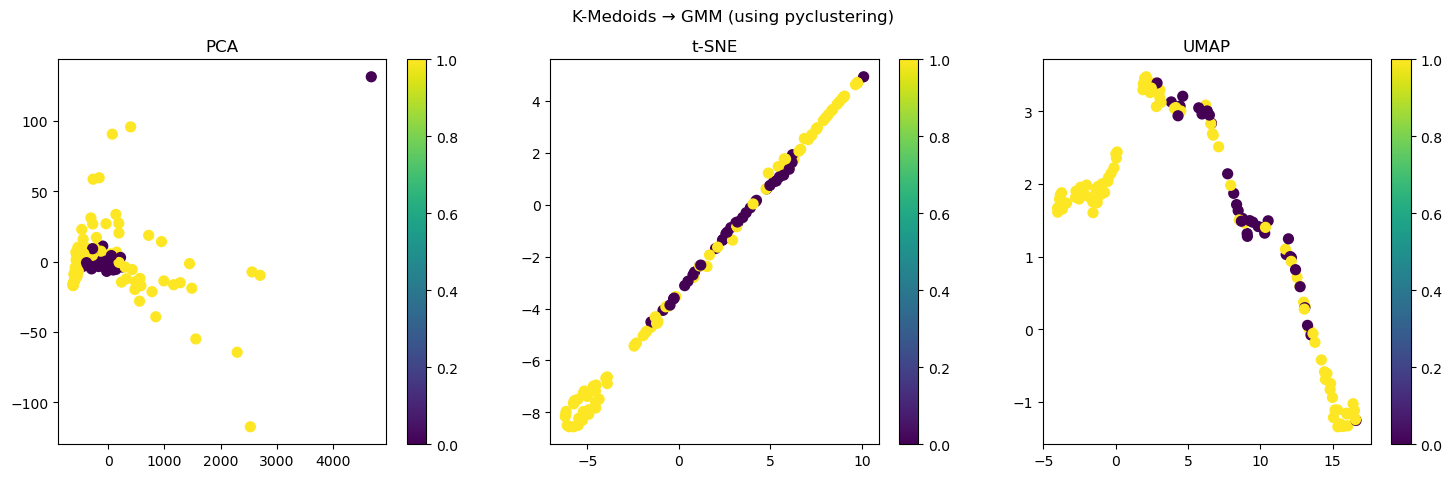

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation and hyperparameter tuning
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler

# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# Alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Update this to your CSV file path
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Alternative K-Medoids using pyclustering
# -------------------------------
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    """
    Runs K-Medoids using pyclustering.
    
    Parameters:
      X           : numpy array of shape (n_samples, n_features)
      n_clusters  : desired number of clusters
      random_state: seed for reproducibility
      
    Returns:
      labels       : numpy array of cluster labels for X
      medoid_coords: numpy array of medoid coordinates used for initialization
    """
    # Convert data to a list-of-lists (pyclustering format)
    data_list = X.tolist()
    n_samples = len(data_list)
    
    # Choose initial medoids randomly using the given random state
    import random
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    
    # Run K-Medoids from pyclustering
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()   # List of clusters (each is a list of indices)
    final_medoids = kmedoids_instance.get_medoids() # Final medoid indices
    
    # Create label array (initialize with -1)
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
            
    # Compute medoid coordinates from final medoid indices
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_clusters(X, labels, title="Clusters"):
    # PCA reduction
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    # t-SNE reduction
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    # UMAP reduction
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = reducer.fit_transform(X)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sc1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axs[0].set_title("PCA")
    plt.colorbar(sc1, ax=axs[0])
    
    sc2 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
    axs[1].set_title("t-SNE")
    plt.colorbar(sc2, ax=axs[1])
    
    sc3 = axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
    axs[2].set_title("UMAP")
    plt.colorbar(sc3, ax=axs[2])
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Pipeline 4: Alternative K-Medoids → GMM (using pyclustering for K-Medoids)
# -------------------------------
def run_pipeline_kmedoids_gmm(X, n_iter=20):
    best_score = -1
    best_params = None
    best_labels = None  # Tuple: (kmed_labels, gmm_labels)
    
    # Random search grid for the number of clusters parameter
    param_grid = {
        'n_clusters': list(range(2, 11))
    }
    param_list = list(ParameterSampler(param_grid, n_iter=n_iter, random_state=random_state))
    
    for params in param_list:
        n_clusters = params['n_clusters']
        # Step 1: Alternative K-Medoids using pyclustering
        try:
            kmed_labels, medoid_coords = run_alternative_kmedoids(X, n_clusters, random_state)
        except Exception as e:
            continue
        
        # Step 2: GMM for probabilistic clustering using medoid centers as initialization
        try:
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X)
            gmm_labels = gmm.predict(X)
        except Exception as e:
            continue
        
        # Evaluate clustering using the silhouette score
        try:
            score = silhouette_score(X, gmm_labels)
        except Exception:
            score = -1
        
        if score > best_score:
            best_score = score
            best_params = params
            best_labels = (kmed_labels, gmm_labels)
    
    print("Pipeline 4 (K-Medoids → GMM) using pyclustering")
    print("Best silhouette score:", best_score)
    print("Best parameters:", best_params)
    return best_labels, best_score

if __name__ == "__main__":
    labels_pipe4, score4 = run_pipeline_kmedoids_gmm(X, n_iter=20)
    if labels_pipe4 is not None:
        kmed_labels, gmm_labels = labels_pipe4
        visualize_clusters(X, gmm_labels, title="K-Medoids → GMM (using pyclustering)")

Pipeline 4 (K-Medoids → GMM) with fixed clusters = 5
Silhouette score: -0.3516715032059284


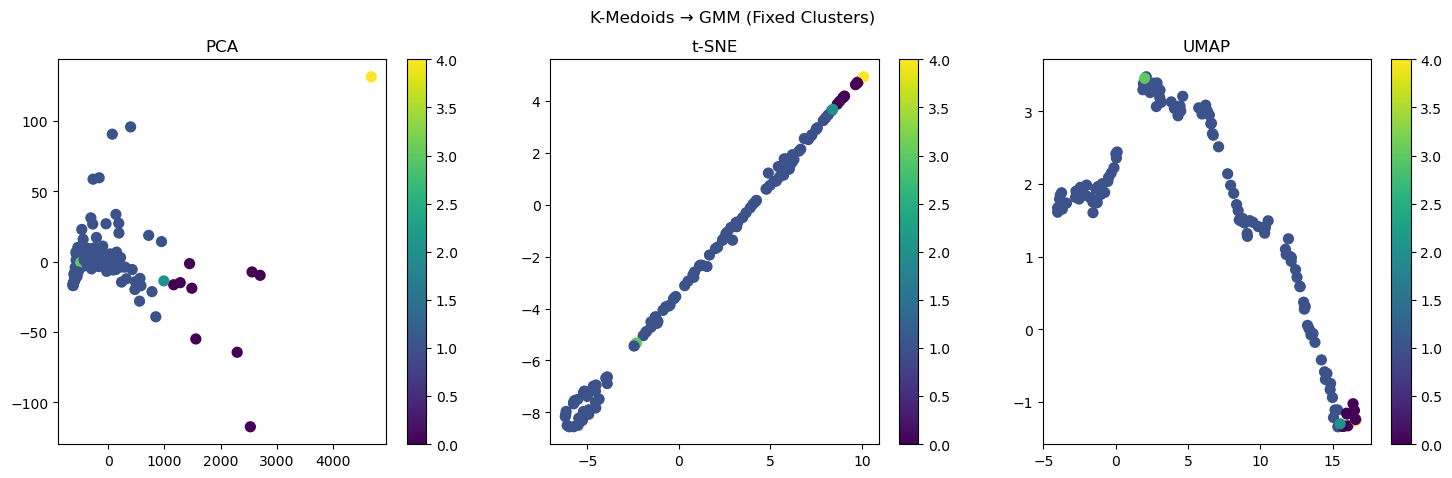

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation
from sklearn.metrics import silhouette_score

# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# Alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids

import random
random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# -------------------------------
# Load CSV file and preprocess data
# -------------------------------
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"  # Update this to your CSV file path
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# -------------------------------
# Alternative K-Medoids using pyclustering
# -------------------------------
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    """
    Runs K-Medoids using pyclustering.
    
    Parameters:
      X           : numpy array of shape (n_samples, n_features)
      n_clusters  : desired number of clusters
      random_state: seed for reproducibility
      
    Returns:
      labels       : numpy array of cluster labels for X
      medoid_coords: numpy array of medoid coordinates used for initialization
    """
    # Convert data to list-of-lists for pyclustering
    data_list = X.tolist()
    n_samples = len(data_list)
    
    # Choose initial medoids randomly using the given random state
    import random
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    
    # Run K-Medoids using pyclustering
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()   # List of clusters (each is a list of indices)
    final_medoids = kmedoids_instance.get_medoids() # Final medoid indices
    
    # Create label array (initialize with -1)
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
            
    # Compute medoid coordinates from final medoid indices
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# -------------------------------
# Visualization Function
# -------------------------------
def visualize_clusters(X, labels, title="Clusters"):
    # PCA reduction
    pca = PCA(n_components=2, random_state=random_state)
    X_pca = pca.fit_transform(X)
    # t-SNE reduction
    tsne = TSNE(n_components=2, random_state=random_state)
    X_tsne = tsne.fit_transform(X)
    # UMAP reduction
    reducer = umap.UMAP(n_components=2, random_state=random_state)
    X_umap = reducer.fit_transform(X)
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    sc1 = axs[0].scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', s=50)
    axs[0].set_title("PCA")
    plt.colorbar(sc1, ax=axs[0])
    
    sc2 = axs[1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=50)
    axs[1].set_title("t-SNE")
    plt.colorbar(sc2, ax=axs[1])
    
    sc3 = axs[2].scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=50)
    axs[2].set_title("UMAP")
    plt.colorbar(sc3, ax=axs[2])
    
    plt.suptitle(title)
    plt.show()

# -------------------------------
# Pipeline 4: K-Medoids → GMM with Fixed Number of Clusters (n=5)
# -------------------------------
def run_pipeline_kmedoids_gmm_fixed(X, fixed_clusters=5):
    """
    Runs Pipeline 4 with a fixed number of clusters.
    
    Parameters:
      X             : numpy array of shape (n_samples, n_features)
      fixed_clusters: fixed number of clusters to use (e.g., 5)
      
    Returns:
      best_labels   : tuple containing (kmed_labels, gmm_labels)
      score         : silhouette score of the final clustering
    """
    n_clusters = fixed_clusters
    # Step 1: Alternative K-Medoids using pyclustering
    try:
        kmed_labels, medoid_coords = run_alternative_kmedoids(X, n_clusters, random_state)
    except Exception as e:
        print("K-Medoids failed:", e)
        return None, None
    
    # Step 2: GMM using the medoid centers as initialization
    try:
        gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
        gmm.fit(X)
        gmm_labels = gmm.predict(X)
    except Exception as e:
        print("GMM failed:", e)
        return None, None
    
    # Evaluate clustering using silhouette score
    try:
        score = silhouette_score(X, gmm_labels)
    except Exception:
        score = -1
    
    print("Pipeline 4 (K-Medoids → GMM) with fixed clusters =", fixed_clusters)
    print("Silhouette score:", score)
    return (kmed_labels, gmm_labels), score

if __name__ == "__main__":
    fixed_clusters = 5  # Set your fixed number of clusters here
    labels_pipe4, score4 = run_pipeline_kmedoids_gmm_fixed(X, fixed_clusters)
    if labels_pipe4 is not None:
        kmed_labels, gmm_labels = labels_pipe4
        visualize_clusters(X, gmm_labels, title="K-Medoids → GMM (Fixed Clusters)")


n_clusters=2: Avg Silhouette Score=0.0133, Stabilization=96.00%
n_clusters=3: Avg Silhouette Score=-0.3180, Stabilization=96.00%
n_clusters=4: Avg Silhouette Score=-0.3890, Stabilization=96.00%
n_clusters=5: Avg Silhouette Score=-0.3517, Stabilization=96.00%
n_clusters=6: Avg Silhouette Score=-0.2611, Stabilization=96.00%
n_clusters=7: Avg Silhouette Score=-0.7117, Stabilization=96.00%
n_clusters=8: Avg Silhouette Score=-0.3006, Stabilization=96.00%
n_clusters=9: Avg Silhouette Score=-0.2212, Stabilization=96.00%
n_clusters=10: Avg Silhouette Score=-0.3994, Stabilization=96.00%


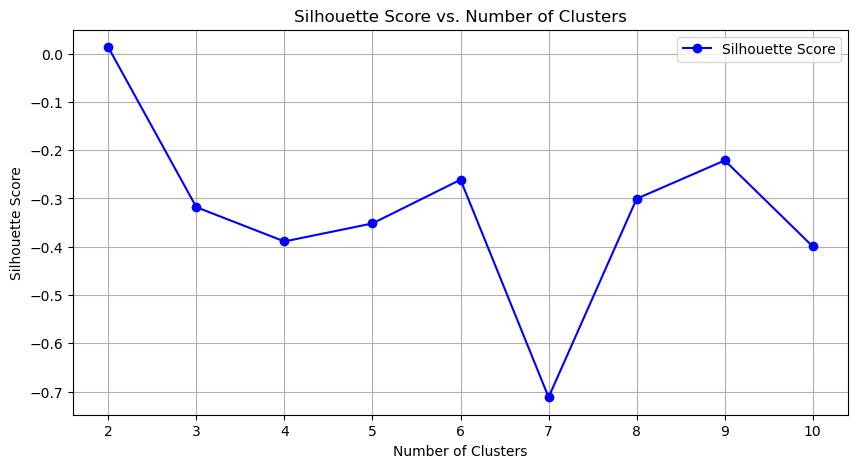

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from pyclustering.cluster.kmedoids import kmedoids
import random

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load CSV file
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# Function to run K-Medoids clustering
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# Function to run Pipeline 4 with multiple rounds
def run_pipeline_kmedoids_gmm(X, n_clusters, rounds=25):
    silhouette_scores = []
    stable_count = 0
    
    for _ in range(rounds):
        try:
            kmed_labels, medoid_coords = run_alternative_kmedoids(X, n_clusters, random_state)
            gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
            gmm.fit(X)
            gmm_labels = gmm.predict(X)
            score = silhouette_score(X, gmm_labels)
            silhouette_scores.append(score)
        except Exception:
            silhouette_scores.append(-1)
        
        if len(silhouette_scores) > 1 and abs(silhouette_scores[-1] - silhouette_scores[-2]) < 0.05:
            stable_count += 1
    
    avg_score = np.mean([s for s in silhouette_scores if s != -1])
    stabilization = (stable_count / rounds) * 100  # Stabilization percentage
    return avg_score, stabilization

# Run for n_clusters = 2 to 10
n_range = range(2, 11)
silhouette_results = []
stabilization_results = []

for n in n_range:
    avg_score, stabilization = run_pipeline_kmedoids_gmm(X, n, rounds=25)
    silhouette_results.append(avg_score)
    stabilization_results.append(stabilization)
    print(f"n_clusters={n}: Avg Silhouette Score={avg_score:.4f}, Stabilization={stabilization:.2f}%")

# Plot Silhouette Score Line Graph
plt.figure(figsize=(10, 5))
plt.plot(n_range, silhouette_results, marker='o', linestyle='-', color='b', label='Silhouette Score')
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs. Number of Clusters")
plt.legend()
plt.grid()
plt.show()

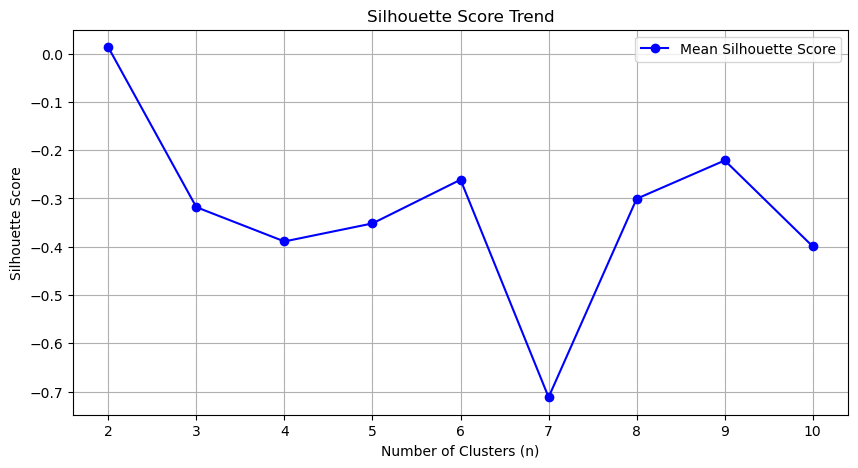

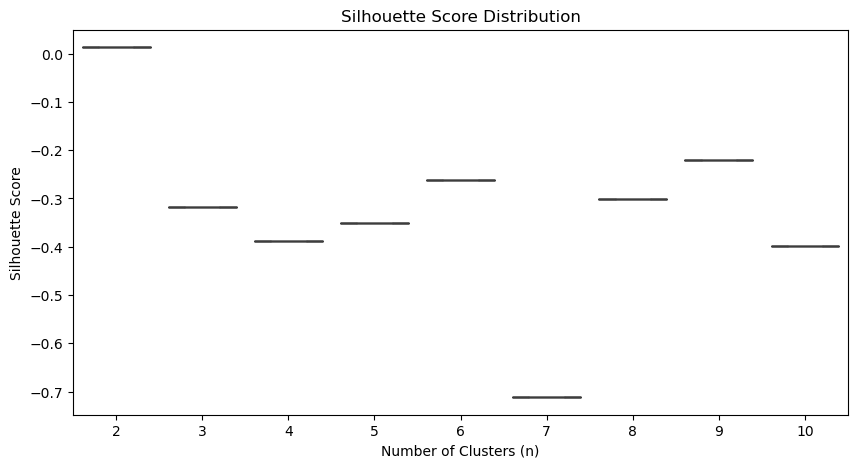

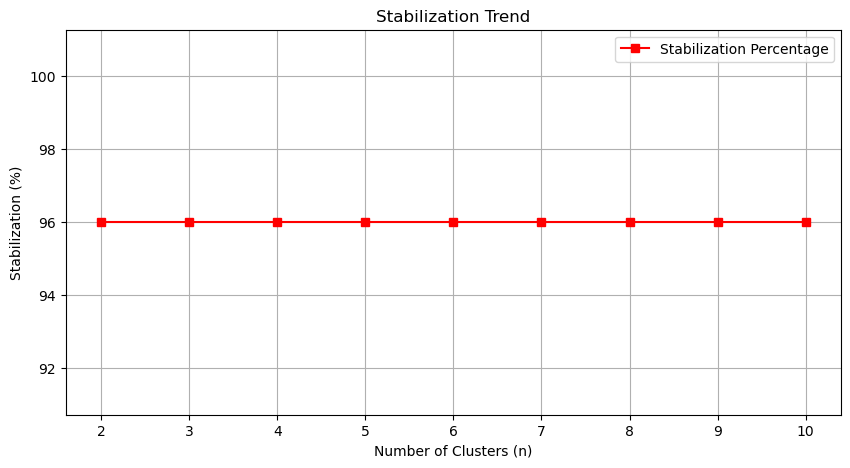

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dimensionality reduction libraries
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

# Clustering evaluation
from sklearn.metrics import silhouette_score

# Gaussian Mixture Model
from sklearn.mixture import GaussianMixture

# Alternative K-Medoids using pyclustering
from pyclustering.cluster.kmedoids import kmedoids
import random

random_state = 42
np.random.seed(random_state)
random.seed(random_state)

# Load CSV file
csv_filename = r"C:\Users\srira\Brain Lab\Clustering algorithms by Sriram Balakrishnan\data_cell_for_clustering.csv"
df = pd.read_csv(csv_filename)
if "Cell Number" in df.columns:
    df = df.drop("Cell Number", axis=1)
X = df.values

# K-Medoids Function
def run_alternative_kmedoids(X, n_clusters, random_state=42):
    data_list = X.tolist()
    n_samples = len(data_list)
    random.seed(random_state)
    initial_medoids = random.sample(range(n_samples), n_clusters)
    kmedoids_instance = kmedoids(data_list, initial_medoids)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    final_medoids = kmedoids_instance.get_medoids()
    labels = np.full(n_samples, -1, dtype=int)
    for cluster_idx, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_idx
    medoid_coords = np.array([X[idx] for idx in final_medoids])
    return labels, medoid_coords

# Pipeline 4 Function
def run_pipeline_kmedoids_gmm(X, n_clusters):
    try:
        kmed_labels, medoid_coords = run_alternative_kmedoids(X, n_clusters, random_state)
    except Exception:
        return None, None
    try:
        gmm = GaussianMixture(n_components=n_clusters, means_init=medoid_coords, random_state=random_state)
        gmm.fit(X)
        gmm_labels = gmm.predict(X)
    except Exception:
        return None, None
    try:
        score = silhouette_score(X, gmm_labels)
    except Exception:
        score = -1
    return gmm_labels, score

# Run experiments
silhouette_scores = {n: [] for n in range(2, 11)}
stabilization_scores = {}
for n in range(2, 11):
    prev_labels = None
    stable_count = 0
    for _ in range(25):
        labels, score = run_pipeline_kmedoids_gmm(X, n)
        if labels is not None:
            silhouette_scores[n].append(score)
            if prev_labels is not None and np.array_equal(prev_labels, labels):
                stable_count += 1
            prev_labels = labels
    stabilization_scores[n] = (stable_count / 25) * 100

# Plot silhouette score trends
plt.figure(figsize=(10, 5))
mean_silhouette = [np.mean(silhouette_scores[n]) for n in range(2, 11)]
plt.plot(range(2, 11), mean_silhouette, marker='o', linestyle='-', color='b', label='Mean Silhouette Score')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Trend')
plt.legend()
plt.grid()
plt.show()

# Box plot for silhouette scores
plt.figure(figsize=(10, 5))
sns.boxplot(data=[silhouette_scores[n] for n in range(2, 11)], notch=True)
plt.xticks(ticks=range(9), labels=range(2, 11))
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Distribution')
plt.show()

# Stabilization plot
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), list(stabilization_scores.values()), marker='s', linestyle='-', color='r', label='Stabilization Percentage')
plt.xlabel('Number of Clusters (n)')
plt.ylabel('Stabilization (%)')
plt.title('Stabilization Trend')
plt.legend()
plt.grid()
plt.show()